# Main notebook for the Assigment

All the experiments described in the report are accessible in this notebook. This notebook was done by Guillaume LEVY: guillaume.levy@student-cs.fr

## Imports

In [1]:
# Import modules
import os
import sys
from IPython.display import clear_output

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import text_flappy_bird_gym
from gymnasium.wrappers.time_limit import TimeLimit
from tqdm import tqdm

from policy import MonteCarlo, Sarsa

## Define plot functions

In [2]:
def plot_heatmap(data, title, xlabel, ylabel, int_precision=False):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if int_precision:
                plt.text(j, i, f"{data[i, j]:.0f}", ha="center", va="center", color="r")
            else:
                plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", color="r")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.tight_layout()
    plt.savefig(f"{title}.png")
    plt.show()


In [3]:
def moving_average(arr, n=3):
    ret = np.cumsum(arr, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
def train_agent(env, agent, n_episodes=1000, eval_every=100):
    all_cumul_rewards = []
    for incr in tqdm(range(n_episodes)):
        # initiate environment
        obs, _ = env.reset()
        done = False
        while not done:
            # Select next action
            action = agent.step(obs, random_action=True)
            # Appy action and return new observation of the environment
            next_obs, reward, done, truncated, _ = env.step(action)
            agent.remember(obs, action, reward, done or truncated, next_obs)
            obs = next_obs

        if incr % eval_every == 0:
            # reset environment
            obs, _ = env.reset()
            cumul_reward = 0
            # iterate
            while True:
                # Select next action
                action = agent.step(obs)

                # Appy action and return new observation of the environment
                obs, reward, done, truncated, _ = env.step(action)
                cumul_reward += reward

                # Render the game
                # os.system("clear")
                # sys.stdout.write(env.render())
                # time.sleep(0.2)  # FPS
                # If player is dead break
                if truncated or done:
                    break
            all_cumul_rewards.append(cumul_reward)

    agent.save()
    return all_cumul_rewards

## Monte Carlo training

### Train agent

In [5]:
#Hyperparameters
NB_EPISODES = 5_000
EVAL_EVERY = 100
MAX_STEPS = 10_000

gamma= 0.95

In [15]:
# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)
# Init agent
agent = MonteCarlo(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma)
all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:22<00:00, 217.57it/s] 


### Plot results

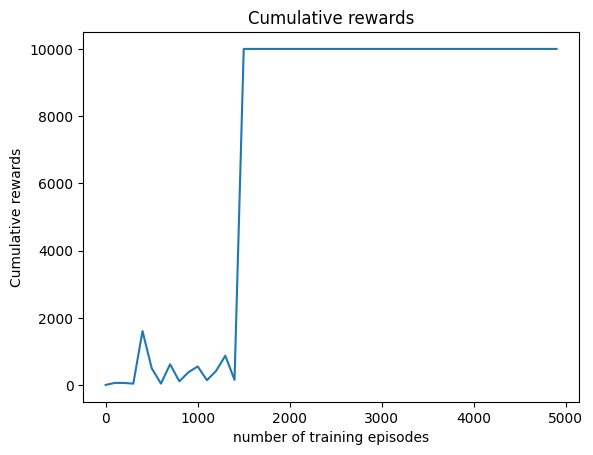

In [16]:
#Save figs
if not os.path.exists("results"):
    os.makedirs("results")
if not os.path.exists("results/" + agent.name):
    os.makedirs("results/" + agent.name)
folder = "results/" + agent.name + "/"
plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY), all_cumul_rewards, label="cumulated rewards")
plt.title("Cumulative rewards")
plt.xlabel("number of training episodes")
plt.ylabel("Cumulative rewards")
plt.savefig(folder + "cumul_rewards.png")


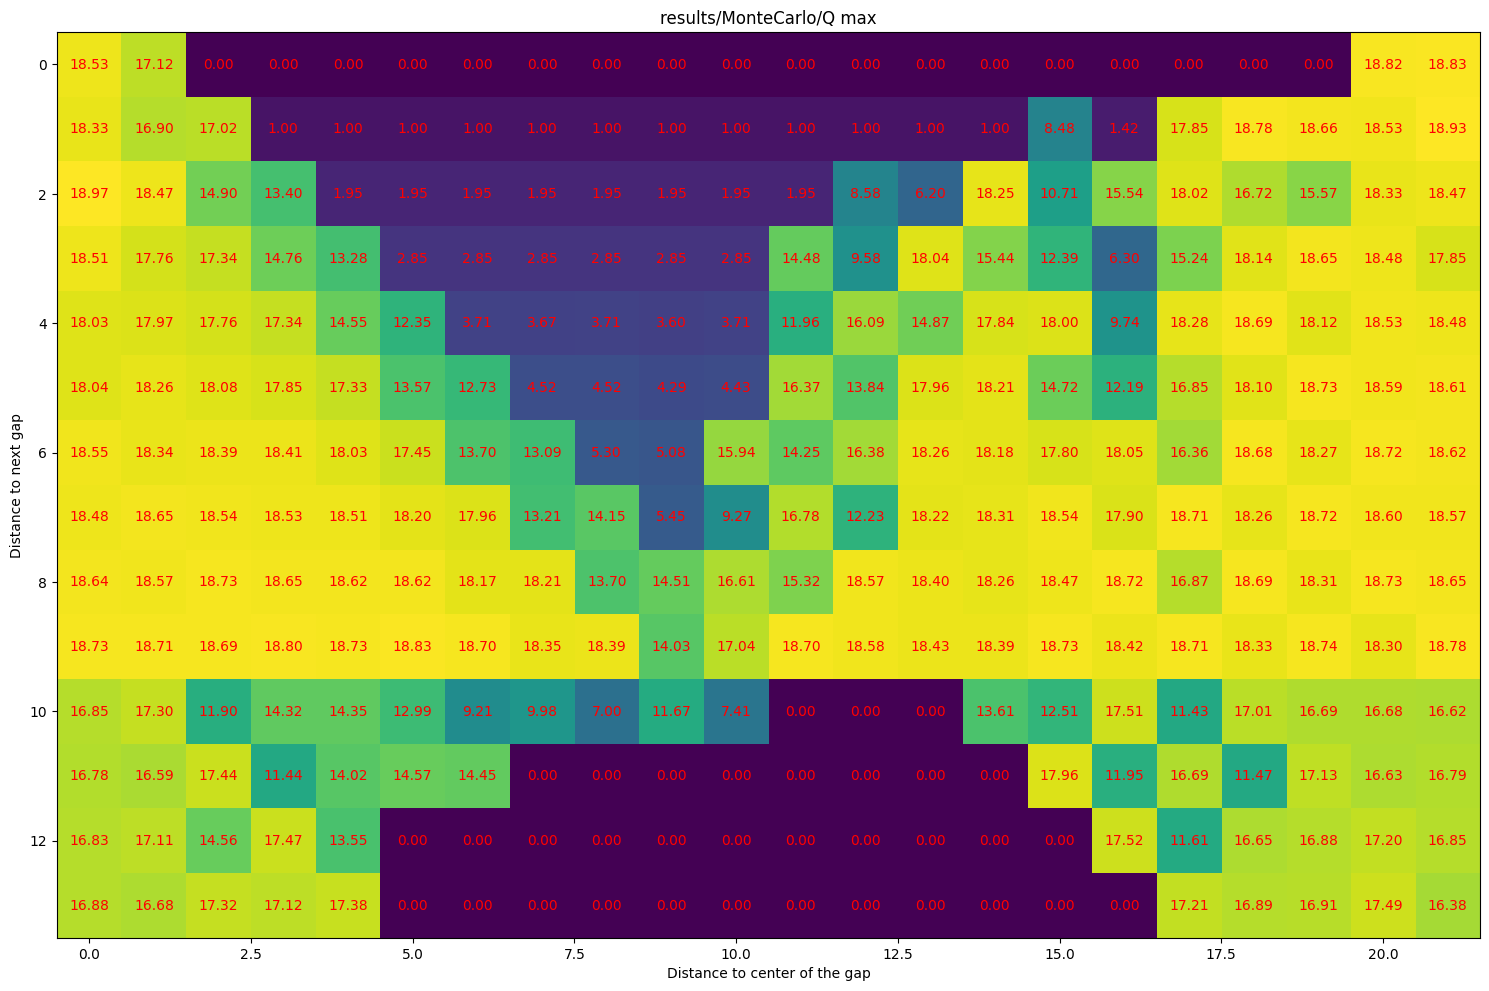

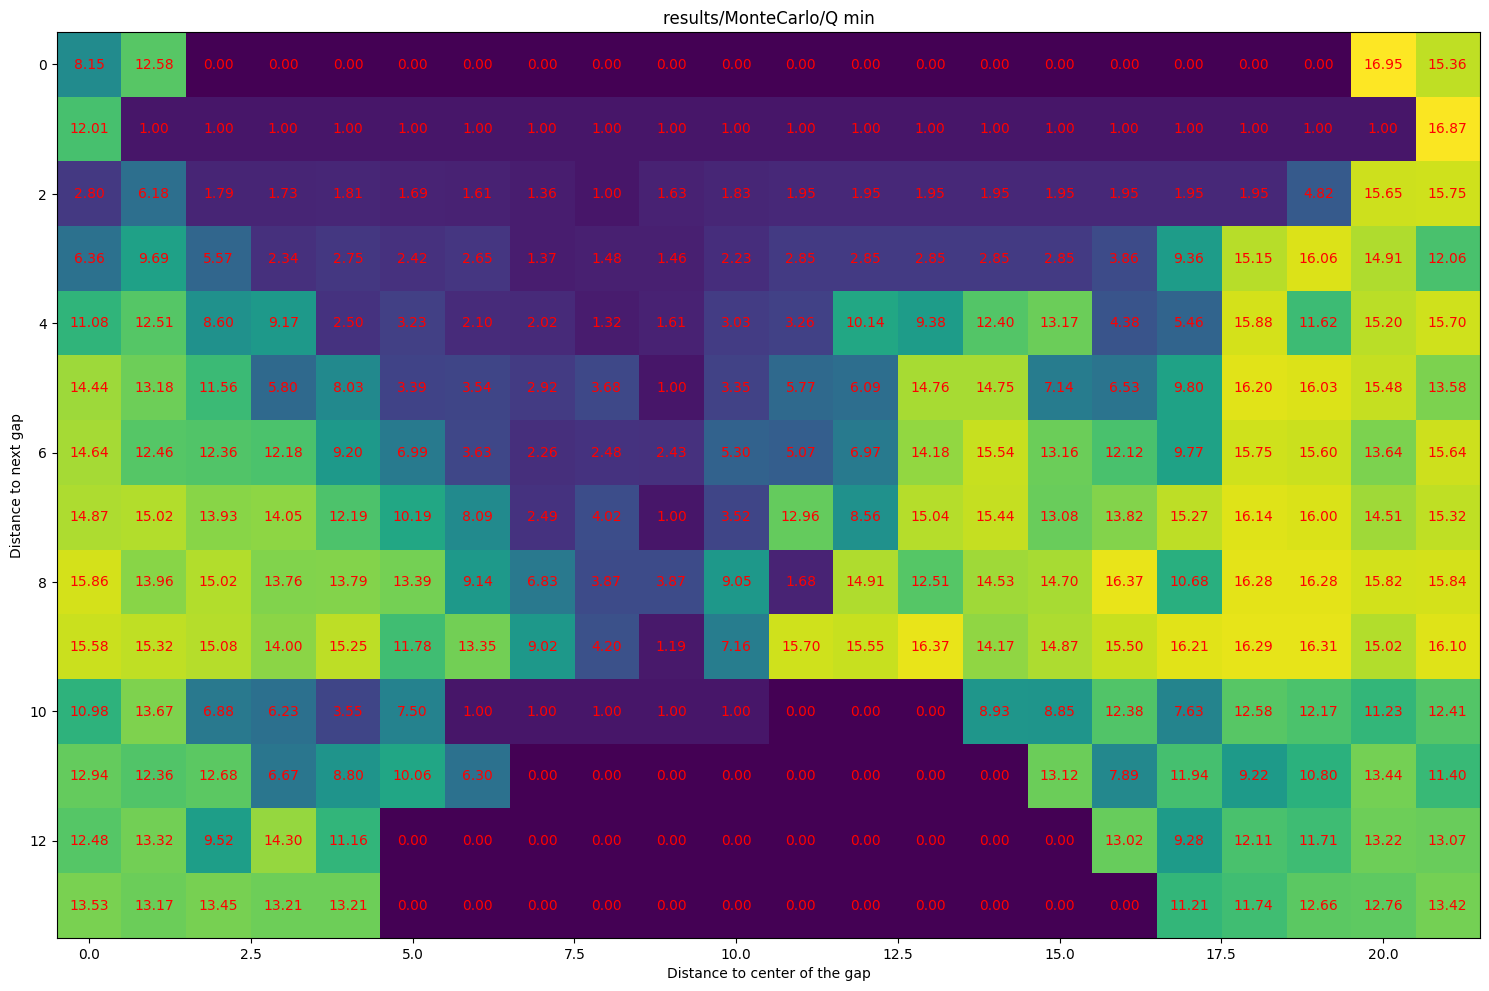

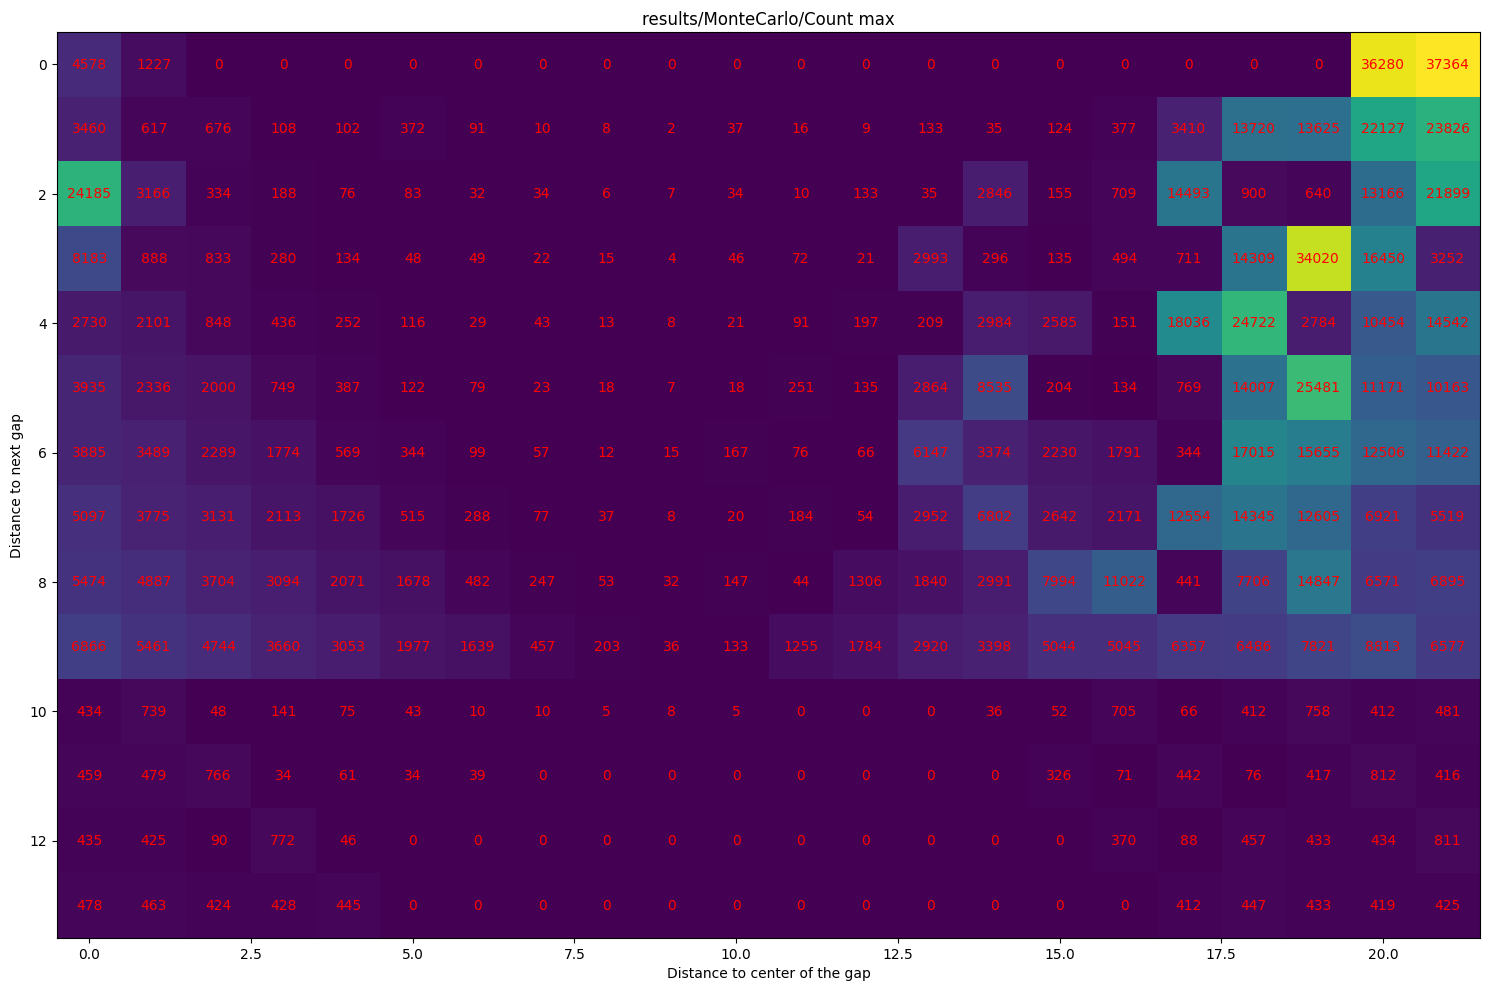

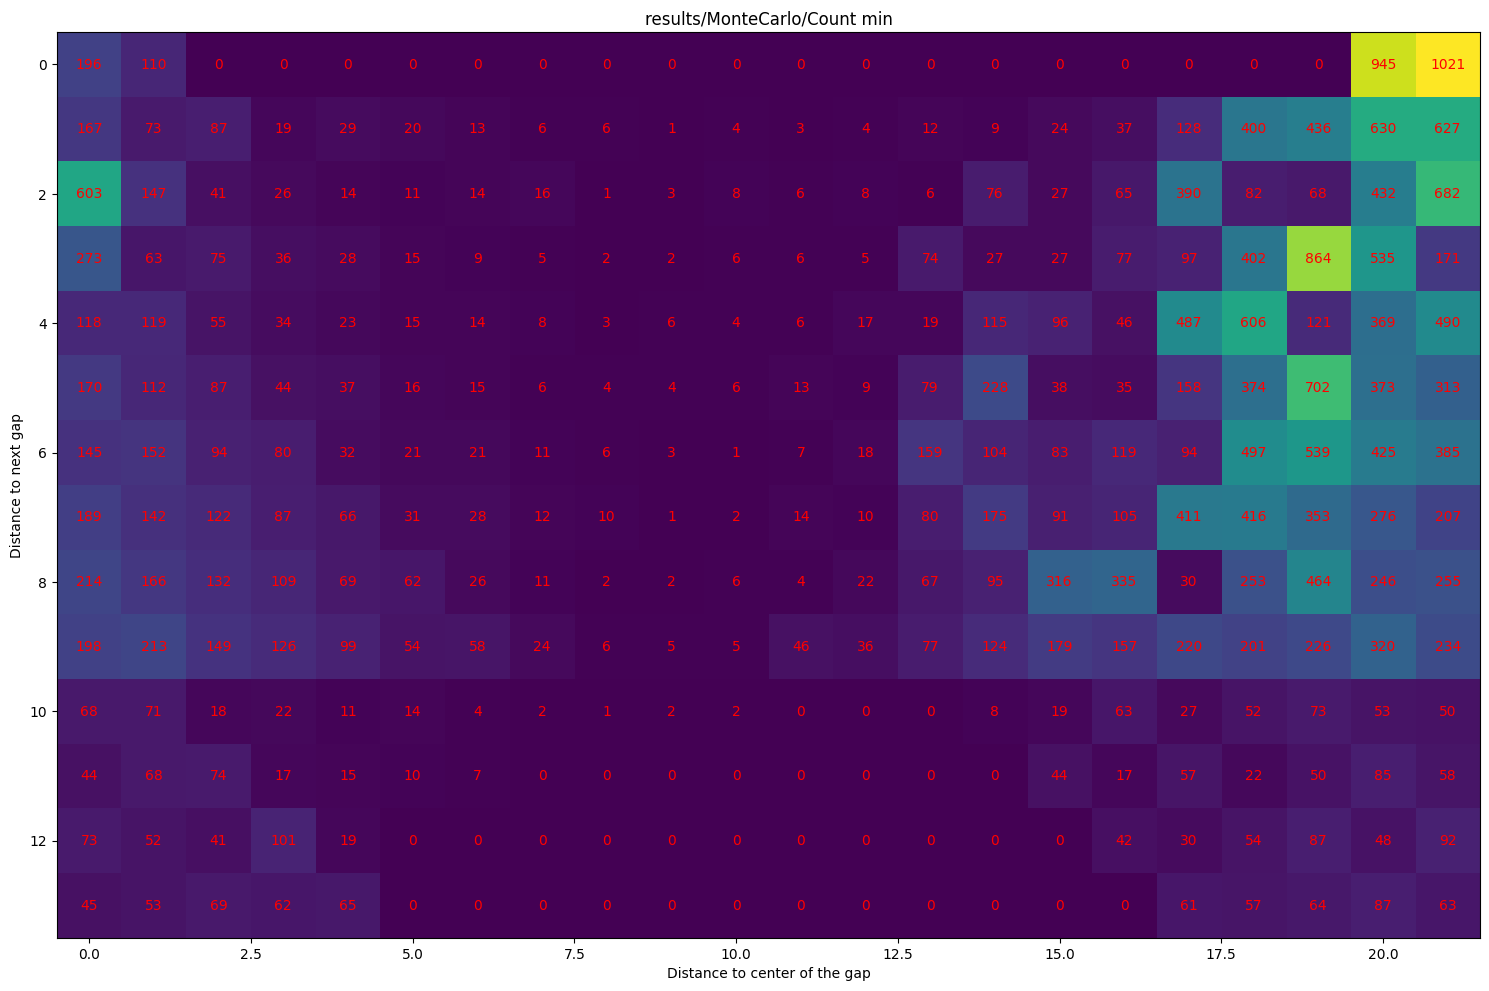

In [17]:
plot_heatmap(agent.Q.max(axis=2), folder + "Q max", xlabel="Distance to center of the gap", ylabel="Distance to next gap")
plot_heatmap(agent.Q.min(axis=2), folder + "Q min", xlabel="Distance to center of the gap", ylabel="Distance to next gap")
plot_heatmap(agent.count.max(axis=2), folder + "Count max", xlabel="Distance to center of the gap", ylabel="Distance to next gap", int_precision=True)
plot_heatmap(agent.count.min(axis=2), folder + "Count min", xlabel="Distance to center of the gap", ylabel="Distance to next gap", int_precision=True)

### Evaluate agent

In [18]:
# Test load
agent.load()

# reset environment
obs, _ = env.reset()

# iterate
while True:
    # Select next action
    action = agent.step(obs)

    # Appy action and return new observation of the environment
    obs, reward, done, truncated, info = env.step(action)

    # Render the game
    clear_output(wait=False)
    sys.stdout.write(env.render())
    sys.stdout.flush()
    # time.sleep(0.2)  # FPS
    # If player is dead break
    if done or truncated:
        if truncated:
            print("Reached Time Limit")
        break

env.close()

Text Flappy Bird!
Score: 999
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[      @  |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=-3)
Reached Time Limit


### Hyperparameters testing

In [35]:
#Hyperparameters
NB_EPISODES = 10_000
EVAL_EVERY = 50
MAX_STEPS = 5_000


# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)

lst_gamma= [1, 0.99, 0.95, 0.9, 0.8,0.5]

all_cumulated_rewards = []
for gamma in lst_gamma:
    agent = MonteCarlo(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma)
    all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)
    all_cumulated_rewards.append(all_cumul_rewards)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:20<00:00, 486.13it/s]


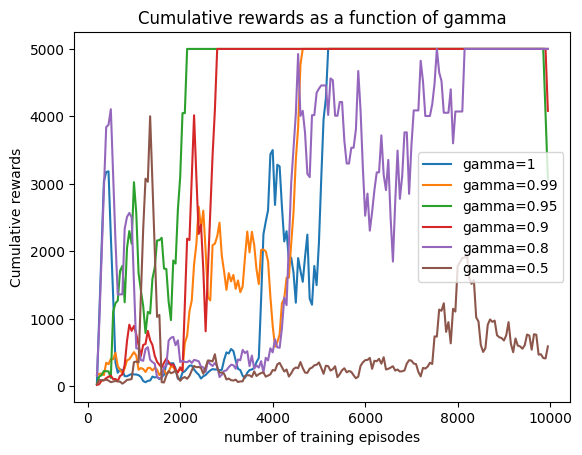

In [37]:
for cumulated_rewards, gamma in zip(all_cumulated_rewards, lst_gamma):
    smooth_rewards = moving_average(cumulated_rewards, n=5)

    plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY)[4:], moving_average(cumulated_rewards, n=5), label=f"gamma={gamma}")
    plt.title("Cumulative rewards as a function of gamma")
    plt.xlabel("number of training episodes")
    plt.ylabel("Cumulative rewards")
    plt.legend()

## Sarsa($\lambda$) training

### Train agent

In [45]:
#Hyperparameters
NB_EPISODES = 5_000
EVAL_EVERY = 100
MAX_STEPS = 10_000

gamma= 0.95
lmbda = 0.9
alpha = 0.1

In [46]:
# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)
# Init agent
agent = Sarsa(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma, lmbda=lmbda, alpha=alpha)
all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)

100%|██████████| 5000/5000 [00:27<00:00, 182.54it/s] 


### Plot results

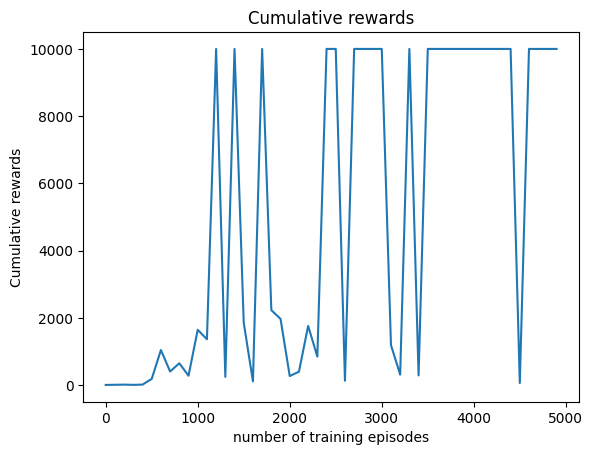

In [47]:
if not os.path.exists("results"):
    os.makedirs("results")
if not os.path.exists("results/" + agent.name):
    os.makedirs("results/" + agent.name)
folder = "results/" + agent.name + "/"
plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY), all_cumul_rewards)
plt.title("Cumulative rewards")
plt.xlabel("number of training episodes")
plt.ylabel("Cumulative rewards")
plt.savefig(folder + "cumul_rewards.png")

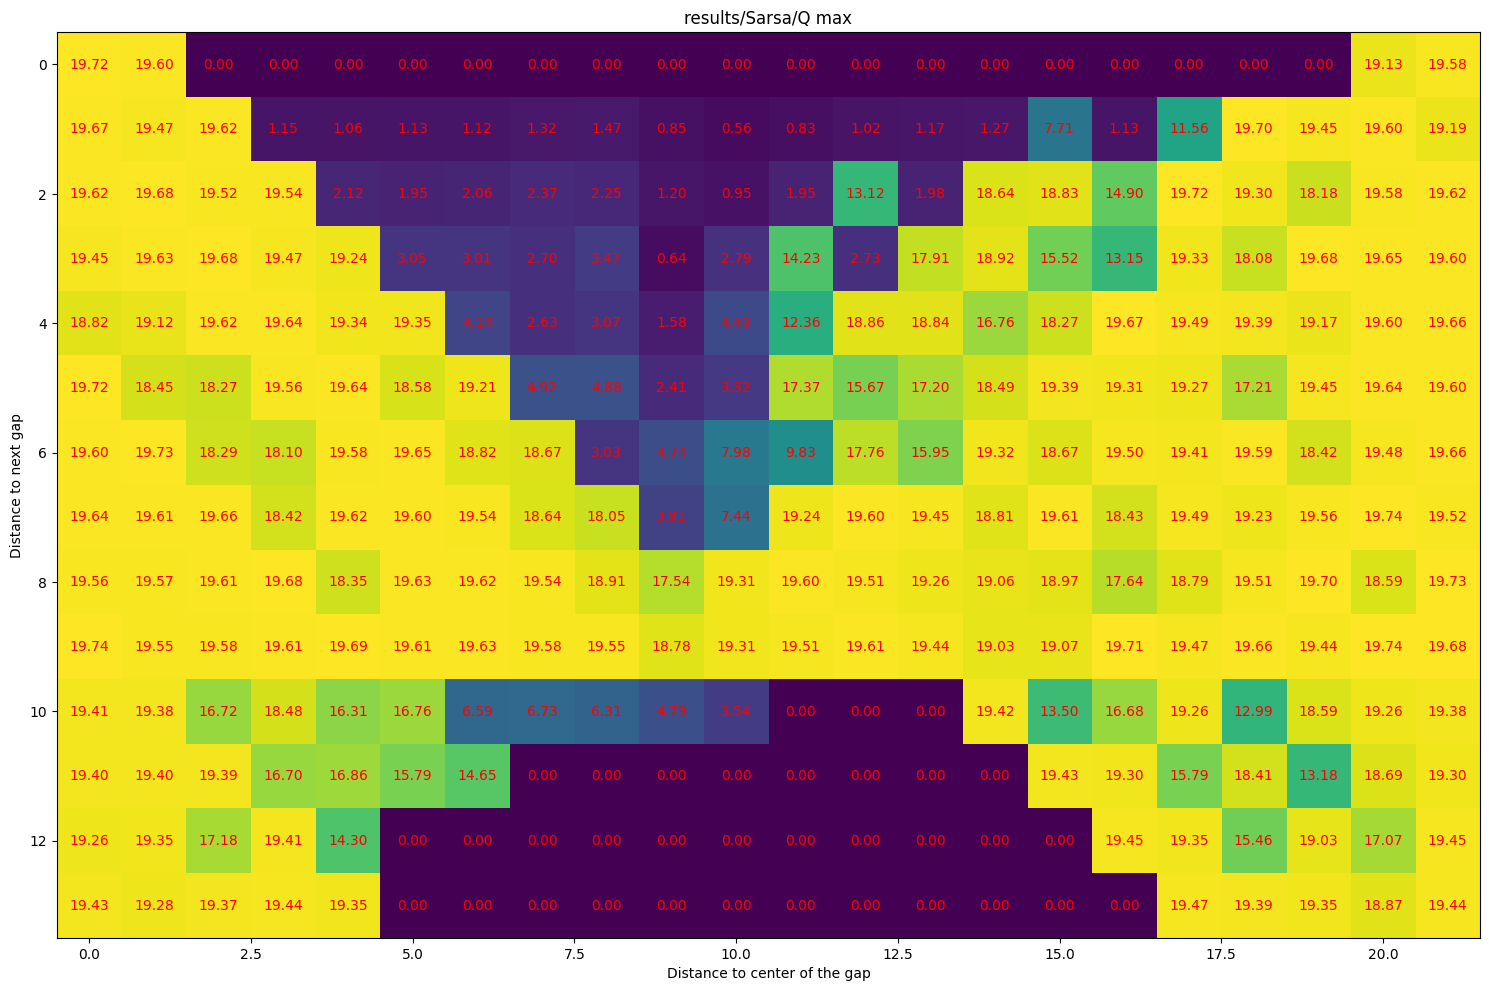

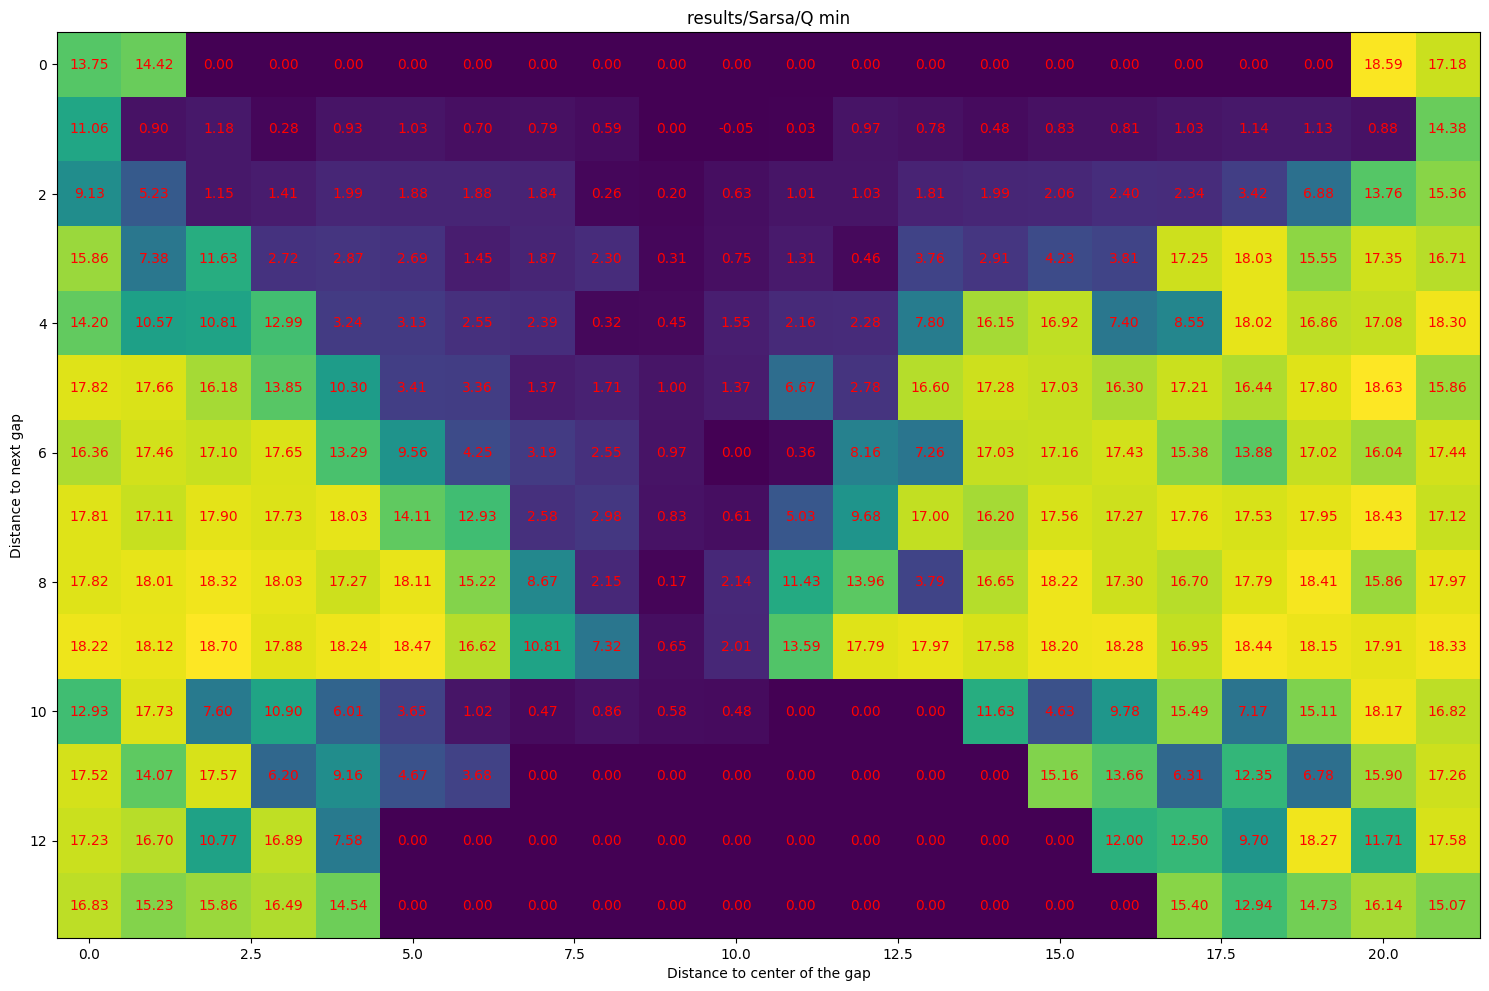

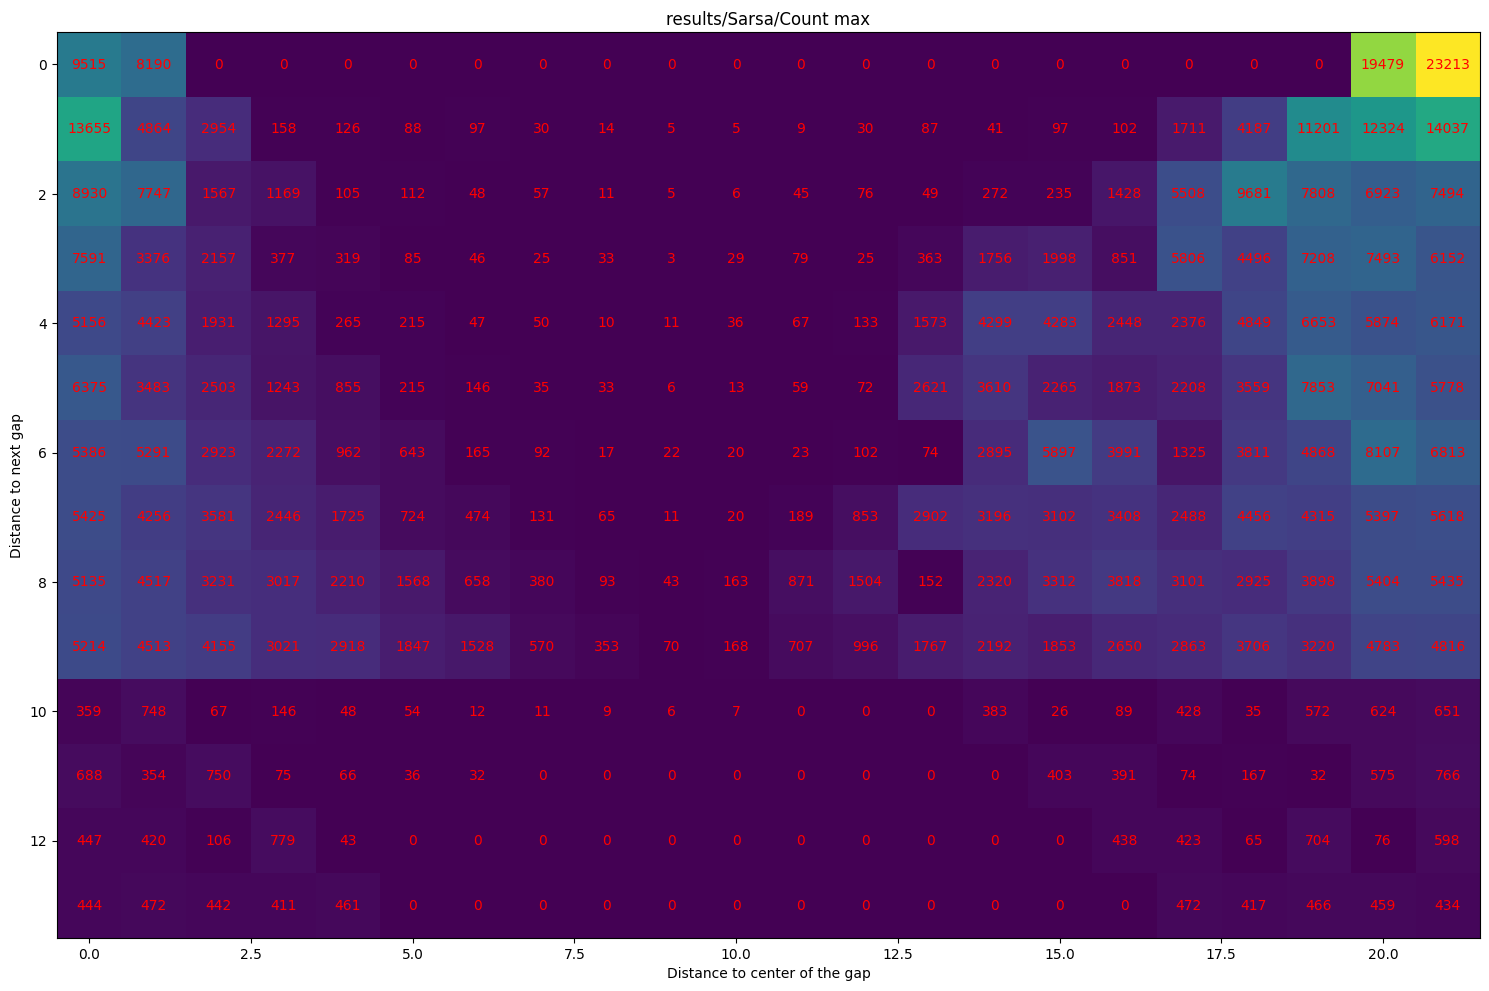

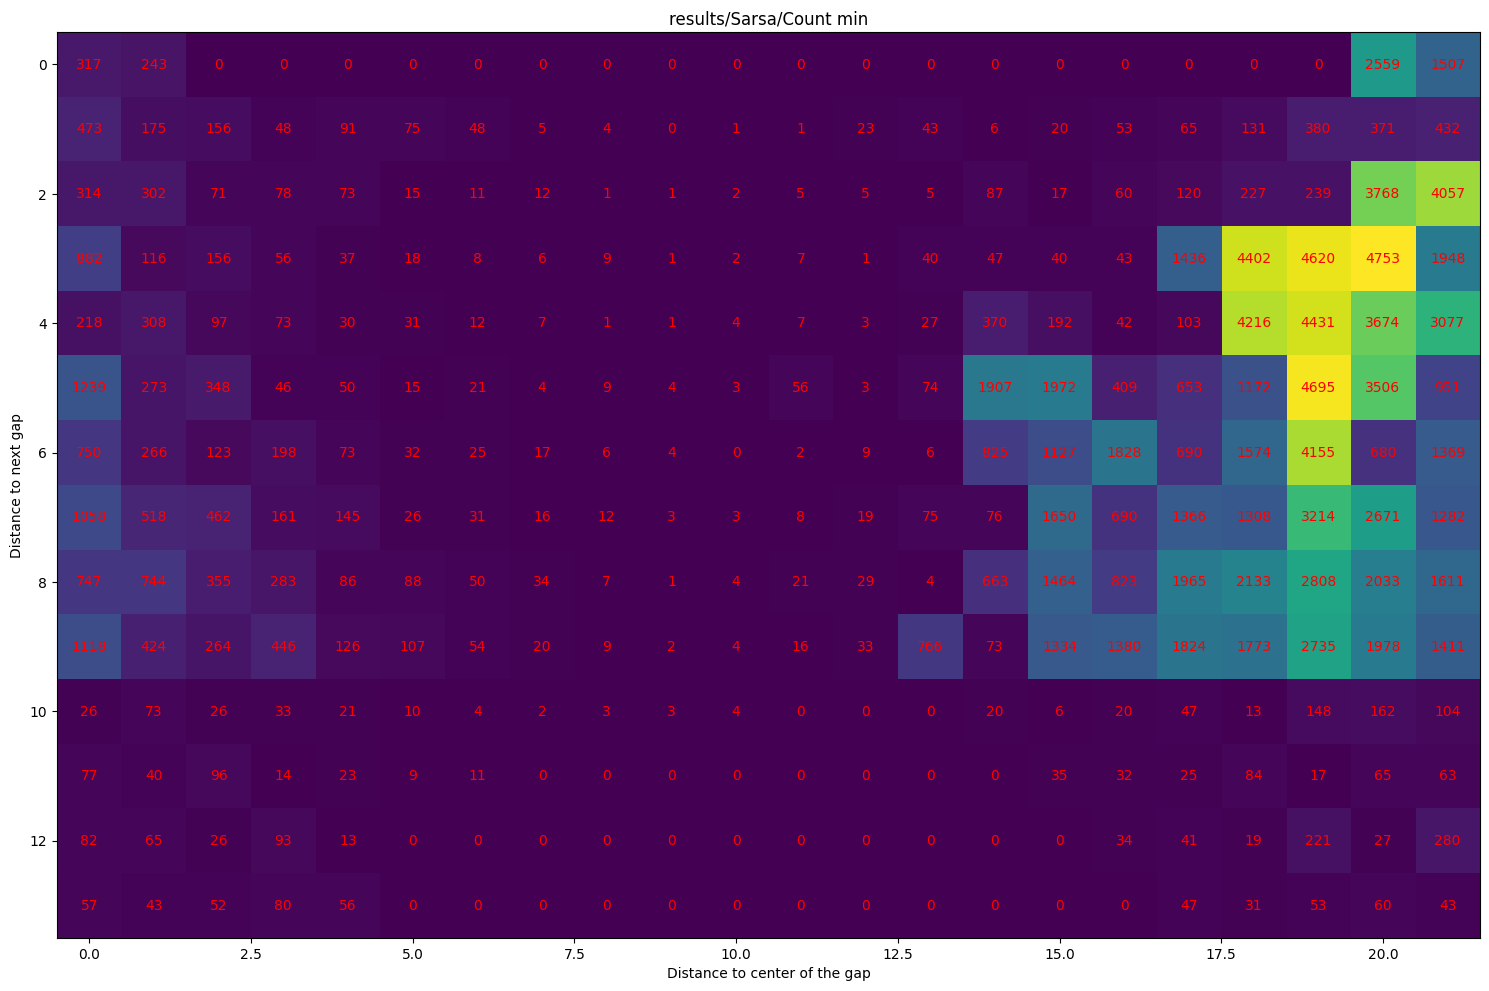

In [48]:
plot_heatmap(agent.Q.max(axis=2), folder + "Q max", xlabel="Distance to center of the gap", ylabel="Distance to next gap")
plot_heatmap(agent.Q.min(axis=2), folder + "Q min", xlabel="Distance to center of the gap", ylabel="Distance to next gap")
plot_heatmap(agent.count.max(axis=2), folder + "Count max", xlabel="Distance to center of the gap", ylabel="Distance to next gap", int_precision=True)
plot_heatmap(agent.count.min(axis=2), folder + "Count min", xlabel="Distance to center of the gap", ylabel="Distance to next gap", int_precision=True)

### Evaluate agent

In [49]:
# Test load
agent.load()

# reset environment
obs, _ = env.reset()

# iterate
while True:
    # Select next action
    action = agent.step(obs)

    # Appy action and return new observation of the environment
    obs, reward, done, truncated, info = env.step(action)

    # Render the game
    clear_output(wait=False)
    sys.stdout.write(env.render())
    sys.stdout.flush()
    # time.sleep(0.2)  # FPS
    # If player is dead break
    if done or truncated:
        if truncated:
            print("Reached Time Limit")
        break

env.close()

Text Flappy Bird!
Score: 999
----------------------
[         |          ]
[         |          ]
[                    ]
[                    ]
[                    ]
[      @             ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=1)
Reached Time Limit


### Hyperparameters testing

In [66]:
#Hyperparameters
NB_EPISODES = 10_000
EVAL_EVERY = 50
MAX_STEPS = 5_000


# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)

lst_gamma= [1, 0.99, 0.95, 0.9, 0.8,0.5]
lmbda = 0.9
alpha = 0.1

all_cumulated_rewards = []
for gamma in lst_gamma:
    agent = Sarsa(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma, lmbda=lmbda, alpha=alpha)
    all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)
    all_cumulated_rewards.append(all_cumul_rewards)

100%|██████████| 10000/10000 [00:18<00:00, 534.50it/s]


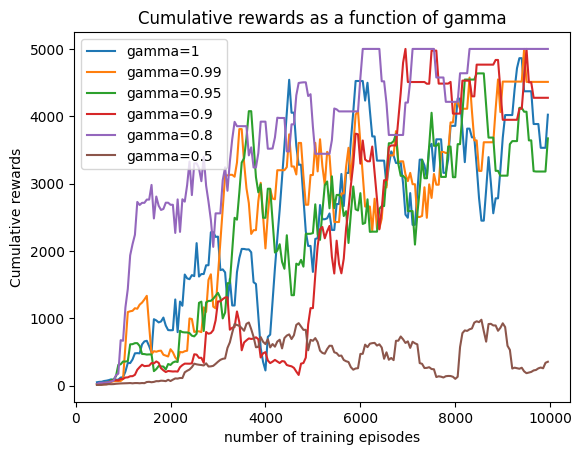

In [67]:
for cumulated_rewards, gamma in zip(all_cumulated_rewards, lst_gamma):
    plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY)[9:], moving_average(cumulated_rewards, n=10), label=f"gamma={gamma}")
    plt.title("Cumulative rewards as a function of gamma")
    plt.xlabel("number of training episodes")
    plt.ylabel("Cumulative rewards")
    plt.legend()

In [74]:
#Hyperparameters
NB_EPISODES = 10_000
EVAL_EVERY = 50
MAX_STEPS = 5_000


# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)

gamma= 0.95
lst_lmbda = [1, 0.9, 0.7, 0.5, 0.3, 0]
alpha = 0.1

all_cumulated_rewards = []
for lmbda in lst_lmbda:
    agent = Sarsa(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma, lmbda=lmbda, alpha=alpha)
    all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)
    all_cumulated_rewards.append(all_cumul_rewards)

100%|██████████| 10000/10000 [00:40<00:00, 247.15it/s]


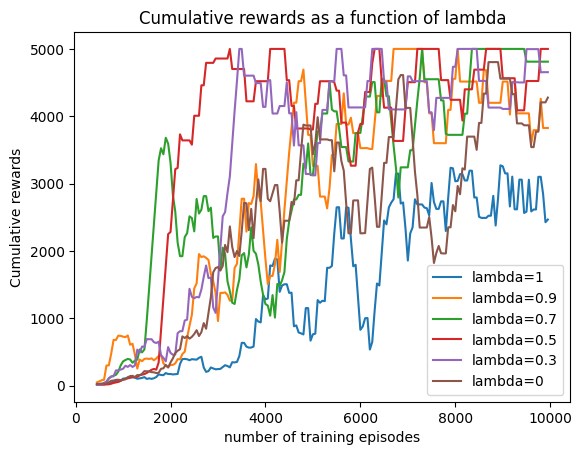

In [75]:
for cumulated_rewards, lmbda in zip(all_cumulated_rewards, lst_lmbda):
    plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY)[9:], moving_average(cumulated_rewards, n=10), label=f"lambda={lmbda}")
    plt.title("Cumulative rewards as a function of lambda")
    plt.xlabel("number of training episodes")
    plt.ylabel("Cumulative rewards")
    plt.legend()

In [64]:
#Hyperparameters
NB_EPISODES = 10_000
EVAL_EVERY = 50
MAX_STEPS = 5_000


# Init environment. We put a max limit in case our agent finds the optimal strategy.
env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)

gamma= 0.95
lmbda = 0.9
lst_alpha = [0.01, 0.05, 0.1, 0.2, 0.5, 1]

all_cumulated_rewards = []
for alpha in lst_alpha:
    agent = Sarsa(env.observation_space, env.action_space, NB_EPISODES, gamma=gamma, lmbda=lmbda, alpha=alpha)
    all_cumul_rewards = train_agent(env, agent, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)
    all_cumulated_rewards.append(all_cumul_rewards)

100%|██████████| 10000/10000 [00:08<00:00, 1148.81it/s]


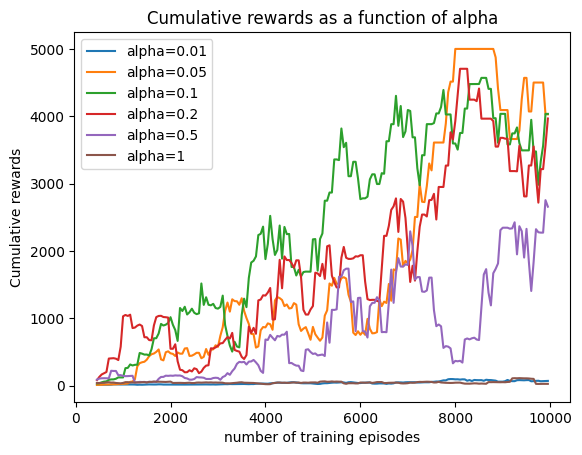

In [65]:
for cumulated_rewards, alpha in zip(all_cumulated_rewards, lst_alpha):
    plt.plot(np.arange(0, NB_EPISODES, EVAL_EVERY)[9:], moving_average(cumulated_rewards, n=10), label=f"alpha={alpha}")
    plt.title("Cumulative rewards as a function of alpha")
    plt.xlabel("number of training episodes")
    plt.ylabel("Cumulative rewards")
    plt.legend()

## Generalization

In [287]:
#Hyperparameters
NB_EPISODES = 10_000
EVAL_EVERY = 100
MAX_STEPS = 5_000

env = TimeLimit(
    gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4), MAX_STEPS
)
agent_mc = MonteCarlo(env.observation_space, env.action_space, NB_EPISODES, gamma=0.95)
_ = train_agent(env, agent_mc, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)
agent_sa = Sarsa(env.observation_space, env.action_space, NB_EPISODES, gamma=0.95, lmbda=0.9, alpha=0.1)
_ = train_agent(env, agent_sa, n_episodes=NB_EPISODES, eval_every=EVAL_EVERY)

100%|██████████| 10000/10000 [00:52<00:00, 191.36it/s]


In [288]:
def evaluate_env(env, agent):
    # reset environment
    obs, _ = env.reset()
    done = False
    # iterate
    nb_steps = 0
    while not done:
        # Select next action
        action = agent.step(obs)

        # Appy action and return new observation of the environment
        obs, _, done, truncated, _ = env.step(action)
        done = done or truncated
        nb_steps += 1

    return nb_steps


### Widths

In [289]:
# Test widths
widths = np.arange(6, 22, 2)
width_scores_mc = []
width_scores_sa = []
for width in widths:
    env = TimeLimit(
        gym.make("TextFlappyBird-v0", height=15, width=width, pipe_gap=4), MAX_STEPS
    )
    width_scores_mc.append(evaluate_env(env, agent_mc))
    width_scores_sa.append(evaluate_env(env, agent_sa))

    env.close()

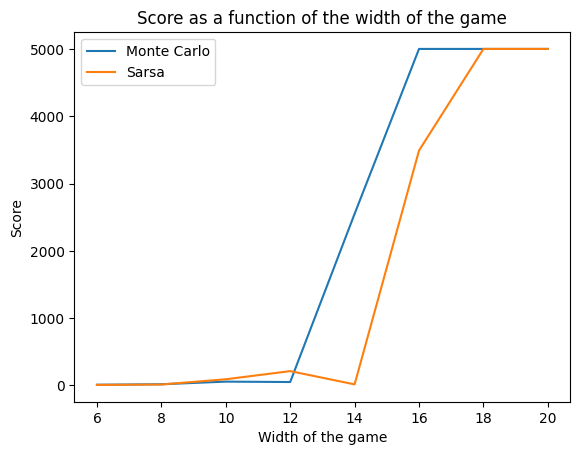

In [290]:
plt.plot(widths,width_scores_mc, label="Monte Carlo")
plt.plot(widths,width_scores_sa, label="Sarsa")
plt.title("Score as a function of the width of the game")
plt.xlabel("Width of the game")
plt.ylabel("Score")
plt.legend()
plt.savefig("results/" + agent.name +"/widths.png")

### Heights

In [291]:
# Test widths
heights = np.arange(9, 21, 2)
height_scores_mc = []
height_scores_sa = []
for height in heights:
    env = TimeLimit(
        gym.make("TextFlappyBird-v0", height=height, width=20, pipe_gap=4), MAX_STEPS
    )
    height_scores_mc.append(evaluate_env(env, agent_mc))
    height_scores_sa.append(evaluate_env(env, agent_sa))

    env.close()

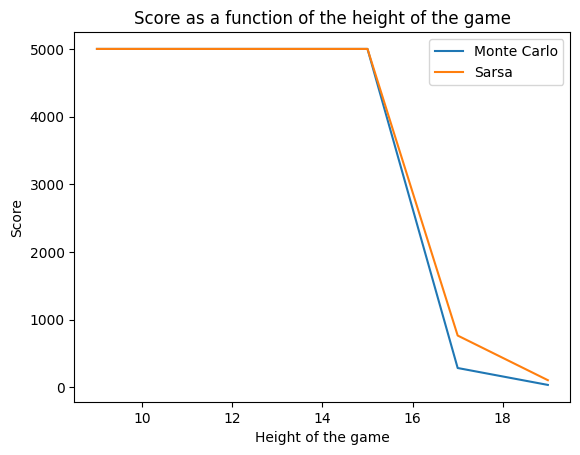

In [292]:
plt.plot(heights,height_scores_mc, label="Monte Carlo")
plt.plot(heights,height_scores_sa, label="Sarsa")
plt.title("Score as a function of the height of the game")
plt.xlabel("Height of the game")
plt.ylabel("Score")
plt.legend()
plt.savefig("results/" + agent.name +"/heights.png")

### Gap

In [297]:
# Test widths
gaps = np.arange(2, 8, 1)
gap_scores_mc = []
gap_scores_sa = []
for gap in gaps:
    env = TimeLimit(
        gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=gap), MAX_STEPS
    )
    gap_scores_mc.append(evaluate_env(env, agent_mc))
    gap_scores_sa.append(evaluate_env(env, agent_sa))

    env.close()

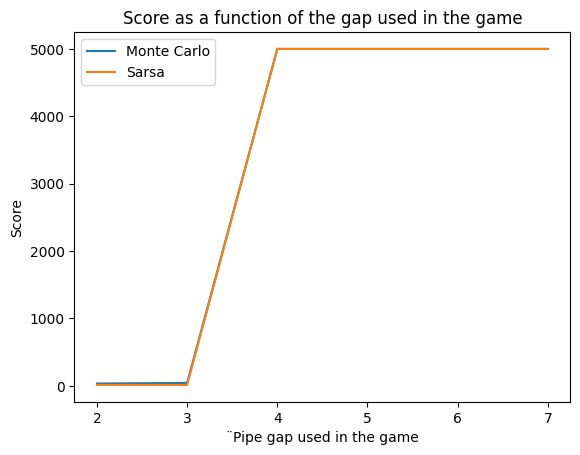

In [298]:
plt.plot(gaps,gap_scores_mc, label="Monte Carlo")
plt.plot(gaps,gap_scores_sa, label="Sarsa")
plt.title("Score as a function of the gap used in the game")
plt.xlabel("¨Pipe gap used in the game")
plt.ylabel("Score")
plt.legend()
plt.savefig("results/" + agent.name +"/gaps.png")